In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import contractions
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Input, LSTM, merge
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2

In [3]:
df = pd.read_table('train.tsv')
df.head()

,Id,EssaySet,Score1,Score2,EssayText
0,1,1,1,1,Some additional information that we would need...
1,2,1,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,1,"What you need is more trials, a control set up..."
3,4,1,0,0,The student should list what rock is better an...
4,5,1,2,2,For the students to be able to make a replicat...


In [4]:
df2 = pd.read_table('train_rel_2.tsv')
df2.head()

,Id,EssaySet,Score1,Score2,EssayText
0,1,1,1,1,Some additional information that we would need...
1,2,1,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,1,"What you need is more trials, a control set up..."
3,4,1,0,0,The student should list what rock is better an...
4,5,1,2,2,For the students to be able to make a replicat...


In [5]:
df.shape

(17207, 5)

In [6]:
df2.shape

(17043, 5)

In [7]:
data = pd.concat([df,df2])

In [8]:
data.shape

(34250, 5)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34250 entries, 0 to 17042
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         34250 non-null  int64 
 1   EssaySet   34250 non-null  int64 
 2   Score1     34250 non-null  int64 
 3   Score2     34250 non-null  int64 
 4   EssayText  34250 non-null  object
dtypes: int64(4), object(1)
memory usage: 1.6+ MB


In [10]:
data.isnull().sum()

Id           0
EssaySet     0
Score1       0
Score2       0
EssayText    0
dtype: int64

In [11]:
data.describe()

,Id,EssaySet,Score1,Score2
count,34250.000000,34250.000000,34250.000000,34250.000000
mean,13791.279124,5.599445,0.927620,0.925518
std,8248.087563,2.819659,0.893225,0.892463
min,1.000000,1.000000,0.000000,0.000000
25%,6272.250000,3.000000,0.000000,0.000000
50%,14229.000000,6.000000,1.000000,1.000000
75%,20908.000000,8.000000,2.000000,2.000000
max,27588.000000,10.000000,3.000000,3.000000


In [12]:
data['EssaySet'].value_counts()

3     3699
8     3598
7     3598
9     3596
6     3594
5     3590
4     3395
1     3344
10    3280
2     2556
Name: EssaySet, dtype: int64

In [13]:
data['Score1'].value_counts()

0    13510
1    11191
2     8067
3     1482
Name: Score1, dtype: int64

In [14]:
data['Score2'].value_counts()

0    13516
1    11263
2     7977
3     1494
Name: Score2, dtype: int64

In [15]:
data.columns

Index(['Id', 'EssaySet', 'Score1', 'Score2', 'EssayText'], dtype='object')

In [16]:
cat_features = [i for i in data.columns if i != 'Id' and i != 'EssayText']

In [17]:
cat_features

['EssaySet', 'Score1', 'Score2']

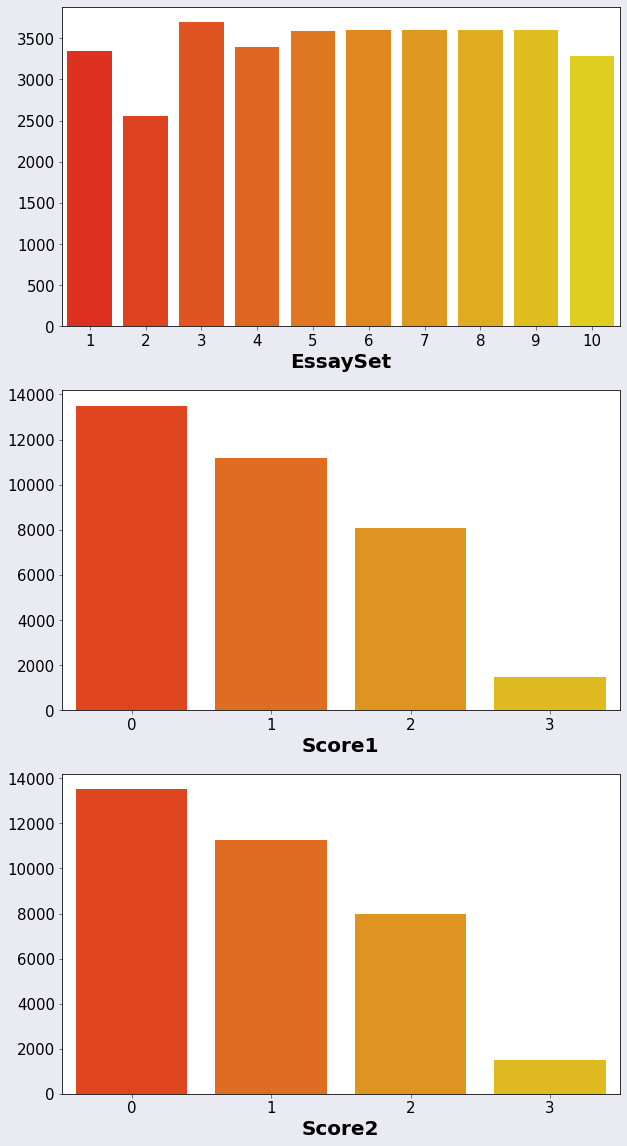

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), facecolor='#EAEAF2')

for r in range(3):
    for c in range(1):
        col = cat_features[r]
        sns.countplot(x=data[col], ax=axes[r], palette='autumn', label='Train data')
        axes[r].set_ylabel('')
        axes[r].set_xlabel(col, fontsize=20, fontweight='bold')
        axes[r].tick_params(labelsize=15, width=0.5)
        axes[r].xaxis.offsetText.set_fontsize(4)
        axes[r].yaxis.offsetText.set_fontsize(4)
plt.show()

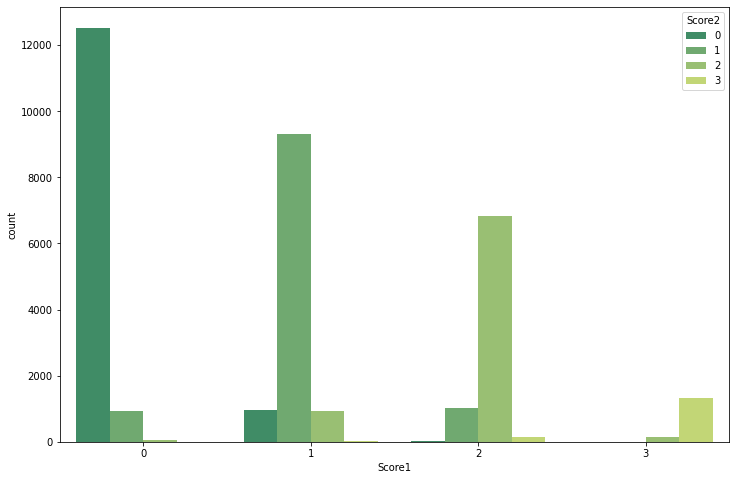

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x=data['Score1'], hue=data['Score2'], palette='summer');

In [20]:
print(f"Most character answer is: {data['EssayText'].str.len().max()} characters")
print(f"least character answer is: {data['EssayText'].str.len().min()} character")

Most character answer is: 1819 characters
least character answer is: 1 character


**each Answer is from 1 to 1819 characters**

In [21]:
score_0_data = list(data['EssayText'][data['Score1'] == 0].values)
score_1_data = list(data['EssayText'][data['Score1'] == 1].values)
score_2_data = list(data['EssayText'][data['Score1'] == 2].values)
score_3_data = list(data['EssayText'][data['Score1'] == 3].values)

In [22]:
score_0_string = ' '.join(score_0_data)
score_1_string = ' '.join(score_1_data)
score_2_string = ' '.join(score_2_data)
score_3_string = ' '.join(score_3_data)

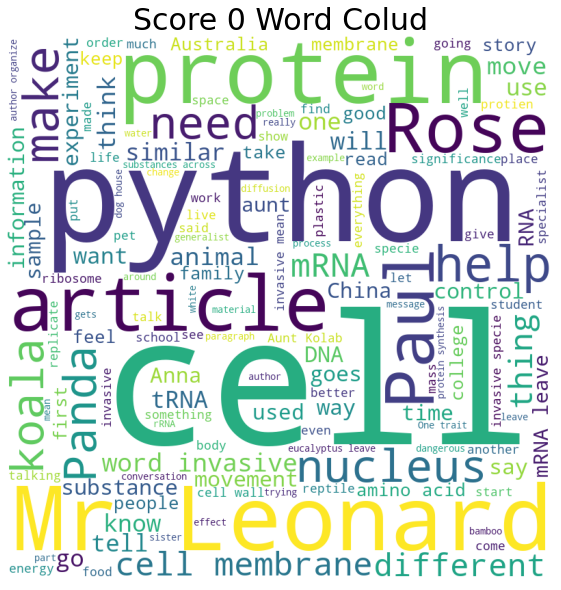

In [23]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_0_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 0 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

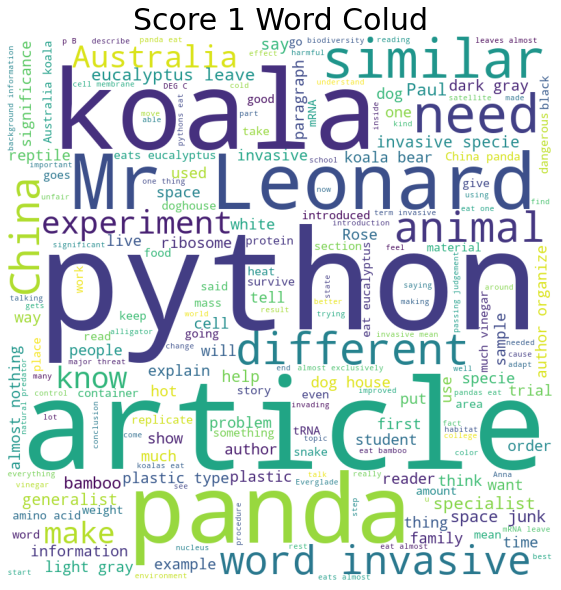

In [24]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_1_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 1 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

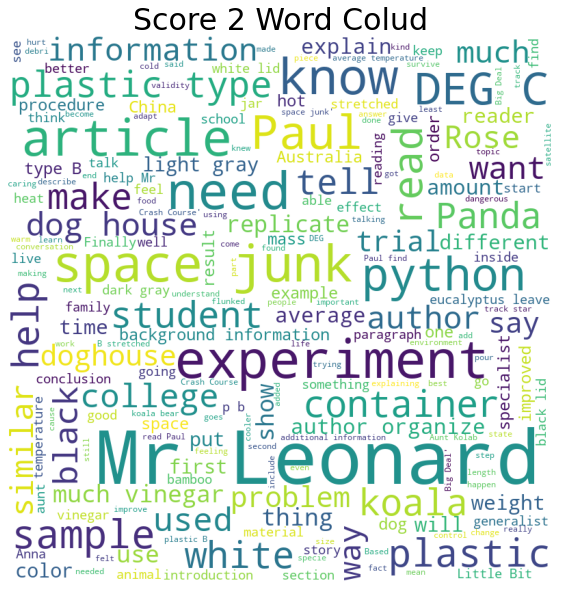

In [25]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_2_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 2 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

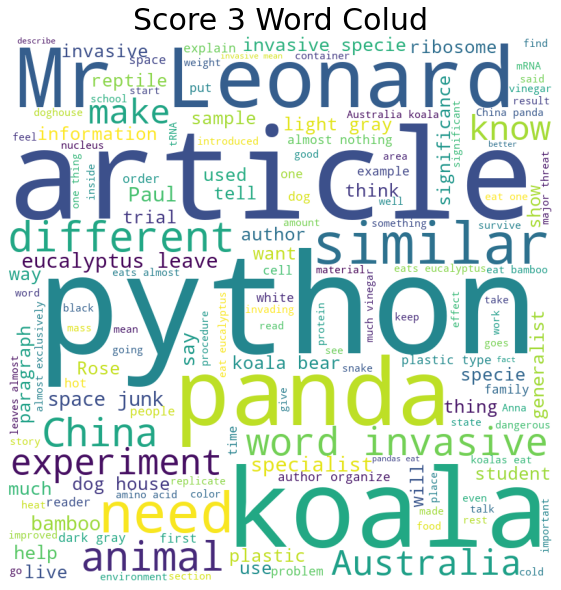

In [26]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(score_1_string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Score 3 Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [27]:
answers_len = data['EssayText'].str.len().values

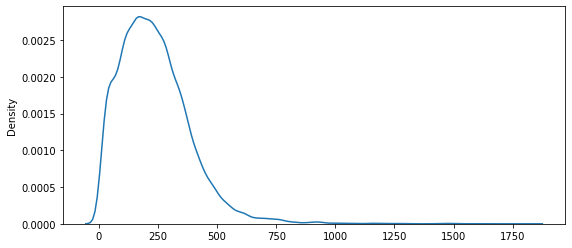

In [28]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=answers_len);

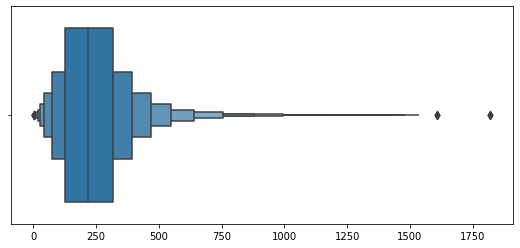

In [29]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=answers_len);

In [30]:
def document_vectorization(document):
    vectorizer = CountVectorizer()
    corpus = vectorizer.fit_transform(document)
    return len(vectorizer.get_feature_names())

In [31]:
number_of_vocabulries = document_vectorization(data['EssayText'])

In [32]:
print(f"Our Vocabulary contains {number_of_vocabulries} word")

Our Vocabulary contains 15921 word


**Before any preprocessing our vocabulry is 15921**

In [33]:
sent_counts = []  # Set of sentence counts in each example response
for x in data['EssayText']:
    sent_counts.append(len(sent_tokenize(x)))

In [34]:
sent_counts[0:5]

[1, 1, 2, 1, 1]

In [35]:
print(f"Max answer contains {max(sent_counts)} sentences")
print(f"Min answer contains {min(sent_counts)} sentences")

Max answer contains 21 sentences
Min answer contains 1 sentences


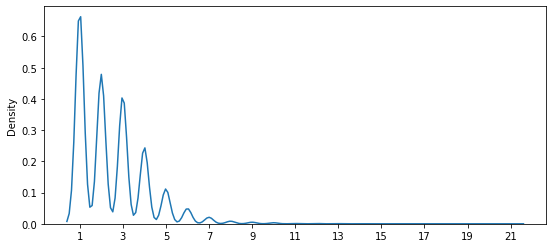

In [36]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=sent_counts);
plt.xticks(np.arange(1,22,2));

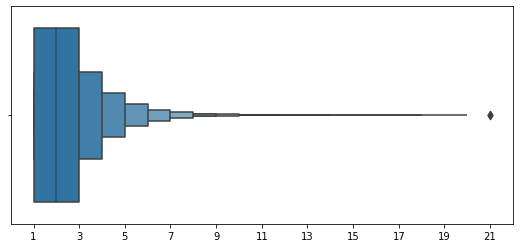

In [37]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=sent_counts)
plt.xticks(np.arange(1,22,2));

In [38]:
word_counts = []
for x in data['EssayText']:
    word_counts.append(len([i for i in word_tokenize(x)]))  

In [39]:
word_counts[0:5]

[58, 54, 39, 18, 33]

In [40]:
print(f"Max answer contains {max(word_counts)} word")
print(f"Min answer contains {min(word_counts)} word")

Max answer contains 369 word
Min answer contains 1 word


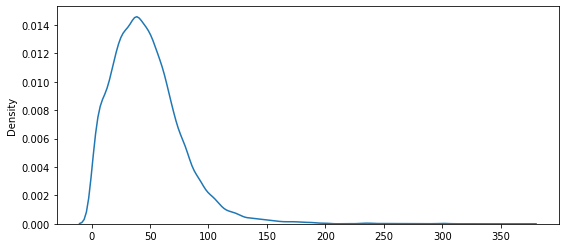

In [41]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=word_counts);

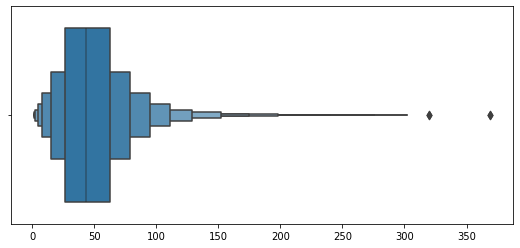

In [42]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=word_counts);

In [43]:
stop_words = stopwords.words('english')

In [45]:
def lowercase_data(data):
    lowercased_data = []
    for sentence in data:
        lowercased_data.append(sentence.lower())
    return lowercased_data



def remove_punctuations(data):
    returned_data = []
    for sentence in data:
        cleaned_data = sentence
        cleaned_data = re.sub(r'[^\w\s]', '', cleaned_data)
        returned_data.append(cleaned_data)
    return returned_data


def tokenized(data):
    filtered_sentence = []
    for sentence in data:
        filtered_sentence.append(word_tokenize(sentence))
    return filtered_sentence


def stemming_remove_stopwords(data):
    returned_data = []
    word_tokens = tokenized(data)
    for tokens in word_tokens:
        sentence = ""
        for word in tokens:
            if word not in stop_words and word != "would":
                stemmer = PorterStemmer()
                sentence += stemmer.stem(word) + ' '
        returned_data.append(sentence)
    return returned_data 


def preprocessing(data):
    new_data = lowercase_data(data)
    new_data = stemming_remove_stopwords(new_data)
    new_data = remove_punctuations(new_data)
    
    return new_data

In [46]:
data2 = data.copy()

In [47]:
data2.drop('EssayText', axis=1, inplace=True)

In [48]:
data2['EssayText'] = preprocessing(data['EssayText'])

In [49]:
data2['EssayText'].head() 

0    addit inform need replic experi much vinegar p...
1    read expir  realiz addit inform need replic ex...
2    need trial  control set  exact amount vinegar ...
3        student list rock better rock wors procedur  
4    student abl make replic  need tell use much vi...
Name: EssayText, dtype: object

In [50]:
number_of_vocabulries_after_preprocess = document_vectorization(data2['EssayText'])
print(f"Our Vocabulary contains {number_of_vocabulries_after_preprocess} word")

Our Vocabulary contains 13259 word


**After preprocessing our vocabulry contains 13259 word**

In [51]:
answers_len_preprocess = data2['EssayText'].str.len()

In [53]:
print(f"Most character answer is: {answers_len_preprocess.max()} character")

Most character answer is: 1006 character


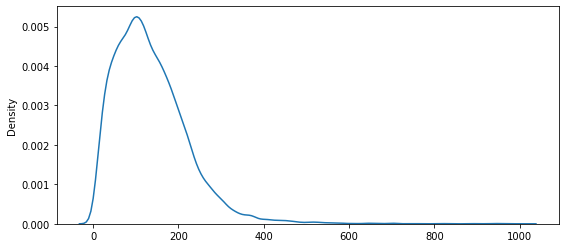

In [54]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=answers_len_preprocess.values);

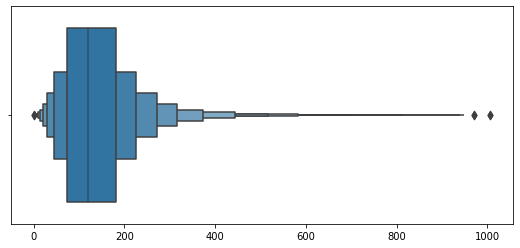

In [55]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=answers_len_preprocess.values);

In [56]:
word_counts_X = []  # Set of sentence counts in each example response
for x in data2['EssayText']:
    word_counts_X.append(len(word_tokenize(x)))

In [57]:
print(f"Max answer contains {max(word_counts_X)} word")

Max answer contains 159 word


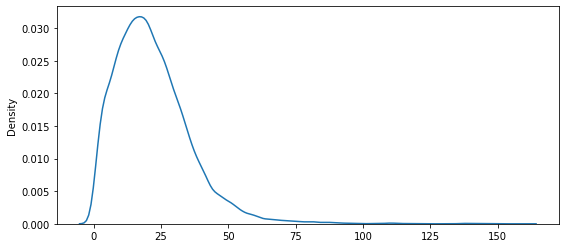

In [58]:
plt.figure(figsize=(9,4))
sns.kdeplot(x=word_counts_X);

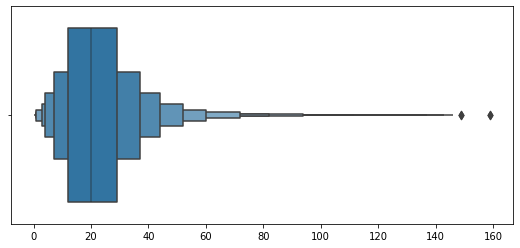

In [59]:
plt.figure(figsize=(9,4))
sns.boxenplot(x=word_counts_X);

In [60]:
texts = data2['EssayText']
labels = data2['Score1']

In [61]:
top_words = 5000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [62]:
word_index = tokenizer.word_index
len(word_index)

13292

In [63]:
sequences[0]

[201,
 29,
 9,
 87,
 21,
 32,
 59,
 121,
 640,
 56,
 589,
 12,
 202,
 94,
 147,
 15,
 31,
 32,
 443,
 159,
 12,
 384,
 147,
 31,
 114,
 59]

In [64]:
max_response_length = 500
data_seq = pad_sequences(sequences, maxlen=max_response_length)

In [65]:
data_seq[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [66]:
labels = data2['Score1']
labels = np.array(labels)

In [67]:
labels[0:5]

array([1, 1, 1, 0, 2], dtype=int64)

In [68]:
data_seq.shape

(34250, 500)

In [69]:
labels.shape

(34250,)

In [70]:
labels2 = to_categorical(np.asarray(labels))

In [71]:
labels2[0:5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [72]:
word_counts_X = np.array(word_counts_X)

sent_counts = np.array(sent_counts)

essay_set = data2['EssaySet']
essay_set = np.array(essay_set)

score2_set = data2['Score2']
score2_set = np.array(score2_set)

In [73]:
word_counts_X[0:5]

array([26, 27, 19,  7, 14])

In [74]:
sent_counts[0:5]

array([1, 1, 2, 1, 1])

In [75]:
essay_set[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [76]:
score2_set[0:5]

array([1, 1, 1, 0, 2], dtype=int64)

**Split our Data 75% Train 25% Test**

In [101]:
mx = 0
for i in data_seq:
    if max(i) > mx:
        mx = max(i)

In [102]:
mx

4999

In [103]:
data_seq_scale = data_seq/4999

In [105]:
word_counts_X_scale = word_counts_X/max(word_counts_X)

In [77]:
X = np.column_stack((data_seq, sent_counts,word_counts_X,sent_counts, essay_set, score2_set))

In [107]:
X2 = np.column_stack((data_seq_scale, sent_counts,word_counts_X_scale,sent_counts, essay_set, score2_set))

In [108]:
X2[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [78]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [79]:
X.shape

(34250, 505)

In [80]:
y = labels
y[0:5]

array([1, 1, 1, 0, 2], dtype=int64)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.25, random_state=42)

In [82]:
print(f"Number of Training Dataset Examples {X_train.shape[0]}")
print(f"Number of Testing Dataset Examples {X_test.shape[0]}")

Number of Training Dataset Examples 25687
Number of Testing Dataset Examples 8563


In [129]:
def train(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def conf_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt='g');
    
def class_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [111]:
lr_model = LogisticRegression(max_iter=30000)
train(lr_model, "Logistic Regression", X2_train, X2_test, y2_train, y2_test)

Logistic Regression model score on Training data: 87.60462490754078%
Logistic Regression model score on Testing data: 87.51605745649888%


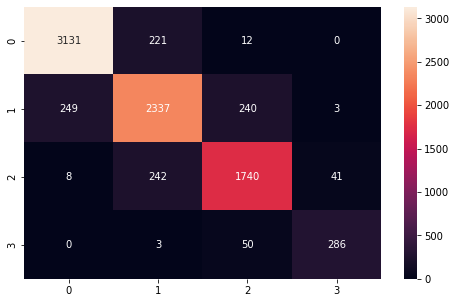

In [126]:
conf_matrix(lr_model, X2_test, y2_test)

In [124]:
class_report(lr_model, X2_test, y2_test)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3364
           1       0.83      0.83      0.83      2829
           2       0.85      0.86      0.85      2031
           3       0.87      0.84      0.86       339

    accuracy                           0.88      8563
   macro avg       0.87      0.86      0.87      8563
weighted avg       0.87      0.88      0.88      8563



In [117]:
rf = RandomForestClassifier()
train(rf, "Random Forest", X2_train, X2_test, y2_train, y2_test)

Random Forest model score on Training data: 99.99610698018454%
Random Forest model score on Testing data: 94.07917785822725%


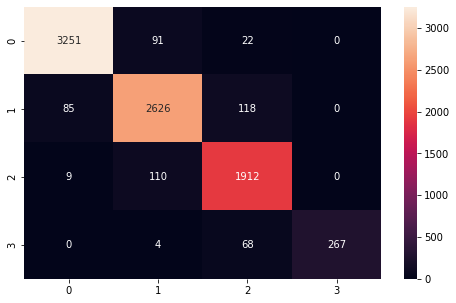

In [127]:
conf_matrix(rf, X2_test, y2_test)

In [128]:
class_report(rf, X2_test, y2_test)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3364
           1       0.93      0.93      0.93      2829
           2       0.90      0.94      0.92      2031
           3       1.00      0.79      0.88       339

    accuracy                           0.94      8563
   macro avg       0.95      0.91      0.92      8563
weighted avg       0.94      0.94      0.94      8563



In [144]:
row = X2.shape[0]
columns = X2.shape[1]

In [171]:
labels2

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [172]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X2, labels2, test_size=0.25)

In [200]:
embedding_vector_length = 32

In [203]:
model = Sequential([
    Input(shape=(505,), name='text'),
    Embedding(output_dim=embedding_vector_length, input_dim=top_words, input_length=505),
    LSTM(100, return_sequences=True),
    LSTM(150),
    Dropout(0.2),
    Dense(200),
    ELU(),
    Dense(4, activation = 'softmax')
])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 505, 32)           160000    
_________________________________________________________________
lstm_79 (LSTM)               (None, 505, 100)          53200     
_________________________________________________________________
lstm_80 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dropout_26 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 200)               30200     
_________________________________________________________________
elu_20 (ELU)                 (None, 200)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 4)               

In [205]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X3_train, y3_train, 
          validation_data = (X3_test , y3_test),
          epochs= 10)  


Epoch 1/10
803/803 [==============================] - 1274s 2s/step - loss: 0.5305 - accuracy: 0.8212 - val_loss: 0.4247 - val_accuracy: 0.8788
Epoch 2/10
803/803 [==============================] - 1379s 2s/step - loss: 0.4251 - accuracy: 0.8742 - val_loss: 0.4097 - val_accuracy: 0.8788
Epoch 3/10
803/803 [==============================] - 1416s 2s/step - loss: 0.4170 - accuracy: 0.8748 - val_loss: 0.4129 - val_accuracy: 0.8788
Epoch 4/10
803/803 [==============================] - 1516s 2s/step - loss: 0.4137 - accuracy: 0.8745 - val_loss: 0.3975 - val_accuracy: 0.8788
Epoch 5/10
803/803 [==============================] - 1429s 2s/step - loss: 0.4120 - accuracy: 0.8747 - val_loss: 0.3940 - val_accuracy: 0.8788
Epoch 6/10
803/803 [==============================] - 1434s 2s/step - loss: 0.4090 - accuracy: 0.8749 - val_loss: 0.3917 - val_accuracy: 0.8788
Epoch 7/10
803/803 [==============================] - 1483s 2s/step - loss: 0.4074 - accuracy: 0.8748 - val_loss: 0.3979 - val_accuracy: